## Data Distribution `Comparisons`
* the aim of this notebook is to plot and show the difference between the `IMERG` rain data and the `SST` and `Navier Stokes` data used in the DYffusion paper.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from pathlib import Path
import seaborn as sns
import numpy as np
import dask
from scipy import io
import xarray as xr
from skimage import exposure

from rainnow.src.configs.data_processing_configs import sequencing_config
from rainnow.src.dyffusion.datamodules.imerg_precipitation import IMERGPrecipitationDataModule
from rainnow.src.plotting import plot_sequence
from rainnow.src.configs.config import PATCH_SIZE
from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.loading import load_imerg_datamodule_from_config
from rainnow.src.utilities.utils import get_device

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensordict/_pytree.py:147: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  register_pytree_node(


#### `helpers.`

In [2]:
device = get_device()
device

Cuda installed! Running on GPU! (device = cuda)


'cuda'

In [3]:
CONFIGS_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/src/dyffusion/configs/"
# CONFIGS_BASE_PATH = "/teamspace/studios/this_studio/irp-ds423/rainnow/src/dyffusion/configs/"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"

#### `instantiate the dataloaders + get batch of data`

In [4]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        #   "normalization": None,
        "boxes": ["0,0", "1,0", "2,0", "2,1"],
        # "boxes": ["0,0"],
        # "boxes": ["1,0"],
        # "boxes": ["2,0"],
        # "boxes": ["2,1"],
    },
)

#### `instantiate PreProcess() object`

In [5]:
# instantiate the pprocessor object.
pprocessor = PreProcess(
    percentiles=datamodule.normalization_hparams["percentiles"],
    minmax=datamodule.normalization_hparams["min_max"],
)

[2024-08-28 18:46:44][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


In [6]:
Xtrain = datamodule.get_ds_xarray("train", datamodule.train_slice)
Xtrain.data

[2024-08-28 18:46:44][imerg_precipitation.py][INFO] --> training, validation & test using 4 (i, j) boxes: ['0,0', '1,0', '2,0', '2,1'].
[2024-08-28 18:46:44][imerg_precipitation.py][INFO] --> train data split: [None, 202301010000]


dask.array<where, shape=(13471, 9, 128, 128), dtype=float64, chunksize=(4817, 9, 128, 128), chunktype=numpy.ndarray>

In [7]:
# convert it to numpy for easier plotting.
data = Xtrain.to_numpy()
data.shape

(13471, 9, 128, 128)

In [8]:
# undersample the data and preprocessed data to be able to plot to have less (speed it up...).
print(f"*** RAW data shape: {data.shape[0]} ***")
jump = 20  # 2%
data_us = data[::jump, :, :, :]
print(f"*** UNDERSAMPLED data shape: {data_us.shape[0]} ***")

*** RAW data shape: 13471 ***
*** UNDERSAMPLED data shape: 674 ***


In [9]:
# max rain intensity in the understampled IMERG data.
data_us.max()

138.2899932861328

In [10]:
# preprocess the data.
data_pprocessed = pprocessor.apply_preprocessing(data_us)

In [13]:
# sns.kdeplot(data_pprocessed.flatten(), color="C0", linewidth=1, label="data pprocessed", alpha=1)
# sns.kdeplot(
#     data_pprocessed[data_pprocessed > 0].flatten(),
#     color="C1",
#     linewidth=1,
#     label="data pprocessed (>0)",
#     alpha=1,
# )

<Axes: ylabel='Density'>

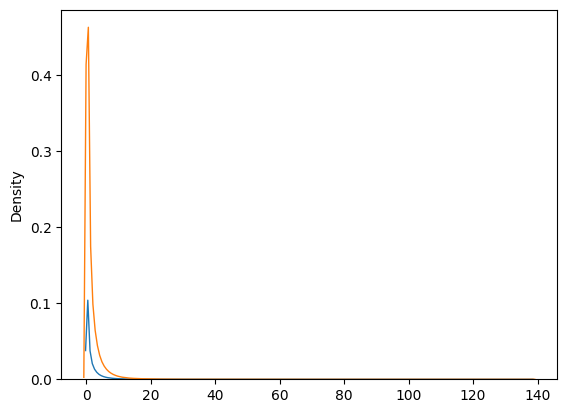

In [14]:
sns.kdeplot(data_us.flatten(), bw_adjust=3, color="C0", linewidth=1, label="raw", alpha=1)
sns.kdeplot(
    data_us[data_us > 0].flatten(), bw_adjust=3, color="C1", linewidth=1, label="raw (>0)", alpha=1
)

#### `Load in a single box of SST data`

In [15]:
# load in SST data.
from functools import partial


def drop_lat_lon_info(ds, time_slice=None):
    """Drop any geographical metadata for lat/lon so that xarrays are
    concatenated along example/grid-box instead of lat/lon dim."""
    if time_slice is not None:
        ds = ds.sel(time=time_slice)
    return ds.assign_coords(lat=np.arange(ds.sizes["lat"]), lon=np.arange(ds.sizes["lon"]))


preprocess = partial(drop_lat_lon_info, time_slice=None)
sst_data = xr.open_mfdataset(
    "data/oisstv2/sst.day.mean.box88.nc", combine="nested", concat_dim="grid_box", preprocess=preprocess
).sst

# convert it to numpy for easier plotting.
sst_data = sst_data.to_numpy()[0, ...]

jump = 10
sst_data = sst_data[::jump, :, :]

sst_data.shape

(1490, 60, 60)

<Axes: ylabel='Density'>

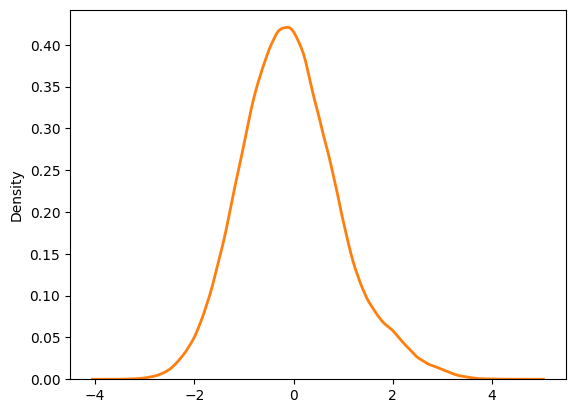

In [16]:
sns.kdeplot(sst_data.flatten(), color="C1", linewidth=2, label="SST")

#### `Get samples of the Navier Stokes Data`

In [17]:
# Code taken directly from https://github.com/Rose-STL-Lab/dyffusion/blob/main/src/datamodules/datasets/physical_systems_benchmark.py to be able to get Navier Stokes data.

import json
import pathlib
from collections import namedtuple

import numpy as np
from einops import rearrange
from torch.utils import data


Trajectory = namedtuple(
    "Trajectory",
    [
        "name",
        "features",
        "dp_dt",
        "dq_dt",
        "t",
        "trajectory_meta",
        "p_noiseless",
        "q_noiseless",
        "masses",
        "edge_index",
        "vertices",
        "fixed_mask",
        "condition",
        "static_nodes",
    ],
)


class TrajectoryDataset(data.Dataset):
    """Returns batches of full trajectories.
    dataset[idx] -> a set of snapshots for a full trajectory"""

    def __init__(self, data_dir, subsample: int = 1, max_samples: int = None):
        super().__init__()
        data_dir = pathlib.Path(data_dir)
        self.subsample = subsample
        self.max_samples = max_samples

        with open(data_dir / "system_meta.json", "r", encoding="utf8") as meta_file:
            metadata = json.load(meta_file)
        self.system = metadata["system"]
        self.system_metadata = metadata["metadata"]
        self._trajectory_meta = metadata["trajectories"]
        self._npz_file = np.load(data_dir / "trajectories.npz")
        if self.system == "navier-stokes":
            self.h, self.w = 221, 42
            self._ndims_p = 2
            self._ndims_q = 1
        elif self.system == "spring-mesh":
            self.h, self.w = 10, 10
            self._ndims_p = 2
            self._ndims_q = 2
        else:
            raise ValueError(f"Unknown system: {self.system}")

    def concatenate_features(self, p, q, channel_dim=-1):
        """How to concatenate any item in the dataset"""
        q = np.expand_dims(q, axis=channel_dim) if q.shape[channel_dim] != 1 and q.ndim <= 2 else q
        assert p.shape[channel_dim] == 2, f"Expected p to have 2 channels but got {p.shape}"
        assert (
            q.shape[channel_dim] == self._ndims_q
        ), f"Expected q to have {self._ndims_q} channel, but got {q.shape}"
        dynamics = np.concatenate([p, q], axis=channel_dim)
        return dynamics

    def __getitem__(self, idx):
        meta = self._trajectory_meta[idx]
        name = meta["name"]
        # Load arrays
        # print([self._trajectory_meta[idx]["name"] for idx in range(self.__len__())])
        # print(f'----> Loading trajectory {name}', meta["field_keys"]["p"])
        p = self._npz_file[meta["field_keys"]["p"]]
        q = self._npz_file[meta["field_keys"]["q"]]
        dp_dt = self._npz_file[meta["field_keys"]["dpdt"]]
        dq_dt = self._npz_file[meta["field_keys"]["dqdt"]]
        t = self._npz_file[meta["field_keys"]["t"]]
        # Handle (possibly missing) noiseless data
        if "p_noiseless" in meta["field_keys"] and "q_noiseless" in meta["field_keys"]:
            # We have explicit noiseless data
            p_noiseless = self._npz_file[meta["field_keys"]["p_noiseless"]]
            q_noiseless = self._npz_file[meta["field_keys"]["q_noiseless"]]
        else:
            # Data must already be noiseless
            p_noiseless = self._npz_file[meta["field_keys"]["p"]]
            q_noiseless = self._npz_file[meta["field_keys"]["q"]]
        # Handle (possibly missing) masses
        if "masses" in meta["field_keys"]:
            masses = self._npz_file[meta["field_keys"]["masses"]]
        else:
            num_particles = p.shape[1]
            masses = np.ones(num_particles)
        if "edge_indices" in meta["field_keys"]:
            edge_index = self._npz_file[meta["field_keys"]["edge_indices"]]
            if edge_index.shape[0] != 2:
                edge_index = edge_index.T
        else:
            edge_index = []
        if "vertices" in meta["field_keys"]:
            vertices = self._npz_file[meta["field_keys"]["vertices"]]
        else:
            vertices = []

        # Handle per-trajectory boundary masks
        if "fixed_mask_p" in meta["field_keys"]:
            fixed_mask_p = np.expand_dims(self._npz_file[meta["field_keys"]["fixed_mask_p"]], 0)
        else:
            fixed_mask_p = [[]]
        if "fixed_mask_q" in meta["field_keys"]:
            fixed_mask_q = np.expand_dims(self._npz_file[meta["field_keys"]["fixed_mask_q"]], 0)
        else:
            fixed_mask_q = [[]]
        if "extra_fixed_mask" in meta["field_keys"]:
            extra_fixed_mask = np.expand_dims(self._npz_file[meta["field_keys"]["extra_fixed_mask"]], 0)
        else:
            extra_fixed_mask = [[]]
        if "enumerated_fixed_mask" in meta["field_keys"]:
            static_nodes = np.expand_dims(self._npz_file[meta["field_keys"]["enumerated_fixed_mask"]], 0)
        else:
            static_nodes = [[]]

        # concatenate the p, q variables into the feature dimension
        features = self.concatenate_features(p, q, channel_dim=-1)

        # Reconstruct spatial dimensions, from (time, 221*42, channel) to (time, channel, 221, 42)
        features = rearrange(features, "time (h w) c -> time c h w", h=self.h, w=self.w).astype(
            np.float32
        )
        efm_pattern = "1 (h w) c -> c h w" if extra_fixed_mask.ndim == 3 else "1 (h w) -> 1 h w"
        q_pattern = "time (h w) -> time 1 h w" if q.ndim == 2 else "time (h w) c -> time c h w"
        q_static_pattern = "(h w) -> h w" if q.ndim == 2 else "(h w) c -> c h w"
        extra_fixed_mask = rearrange(extra_fixed_mask, efm_pattern, h=self.h, w=self.w)
        dp_dt = rearrange(dp_dt, "time (h w) c -> time c h w", h=self.h, w=self.w).astype(np.float32)
        dq_dt = rearrange(dq_dt, q_pattern, h=self.h, w=self.w).astype(np.float32)
        p_noiseless = rearrange(p_noiseless, "time (h w) c -> time c h w", h=self.h, w=self.w).astype(
            np.float32
        )
        q_noiseless = rearrange(q_noiseless, q_pattern, h=self.h, w=self.w).astype(np.float32)
        masses = rearrange(masses, "(h w) -> h w", h=self.h, w=self.w)
        vertices = (
            rearrange(vertices, "(h w) c -> c h w", h=self.h, w=self.w).astype(np.float32)
            if len(vertices) > 0
            else []
        )
        static_nodes = (
            rearrange(static_nodes.squeeze(), "(h w) -> h w", h=self.h, w=self.w)
            if len(static_nodes[0]) > 0
            else []
        )
        fixed_mask_p = rearrange(fixed_mask_p.squeeze(), "(h w) c -> c h w", h=self.h, w=self.w)
        fixed_mask_q = rearrange(fixed_mask_q.squeeze(), q_static_pattern, h=self.h, w=self.w)
        fixed_mask = self.concatenate_features(fixed_mask_p, q=fixed_mask_q, channel_dim=0)
        if self.subsample > 1:
            meta["time_step_size"] = meta["time_step_size"] * self.subsample
            features = features[:: self.subsample]
            dp_dt = dp_dt[:: self.subsample]
            dq_dt = dq_dt[:: self.subsample]
            p_noiseless = p_noiseless[:: self.subsample]
            q_noiseless = q_noiseless[:: self.subsample]
            t = t[:: self.subsample]
            meta["num_time_steps"] = len(t)

        # Package and return
        return Trajectory(
            name=name,
            trajectory_meta=meta,
            features=features,
            dp_dt=dp_dt,
            dq_dt=dq_dt,
            t=t,
            p_noiseless=p_noiseless,
            q_noiseless=q_noiseless,
            masses=masses,
            edge_index=edge_index,
            vertices=vertices,
            fixed_mask=fixed_mask,
            condition=extra_fixed_mask,
            static_nodes=static_nodes,
        )

    def __len__(self):
        return len(self._trajectory_meta) if self.max_samples is None else self.max_samples

In [18]:
ns_data_file_dir = "/teamspace/studios/this_studio/data/navier-stokes/nn-benchmark-data-navier-stokes-multi/navier-stokes-multi/run/data_gen/ns-runs_train-navier-stokes-n100-t65-n0_00001"

# instantiate a TrajectoryDataset()
NavierStokes = TrajectoryDataset(ns_data_file_dir)

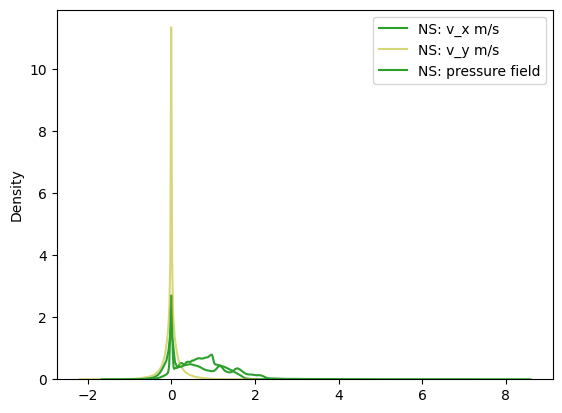

In [19]:
trajectories = np.vstack(
    [NavierStokes.__getitem__(i).features for i in range(0, NavierStokes.__len__(), 10)]
)
v_x = trajectories[:, 0, ...]
v_y = trajectories[:, 1, ...]
pressure_field = trajectories[:, 2, ...]

fig, axs = plt.subplots()
sns.kdeplot(v_x.flatten(), ax=axs, color="C2", label=f"NS: v_x m/s")
sns.kdeplot(v_y.flatten(), ax=axs, color="C8", label=f"NS: v_y m/s", alpha=0.6)
sns.kdeplot(pressure_field.flatten(), ax=axs, color="C12", label=f"NS: pressure field")
axs.legend(loc="best")

#### `Plot the KDEs together`

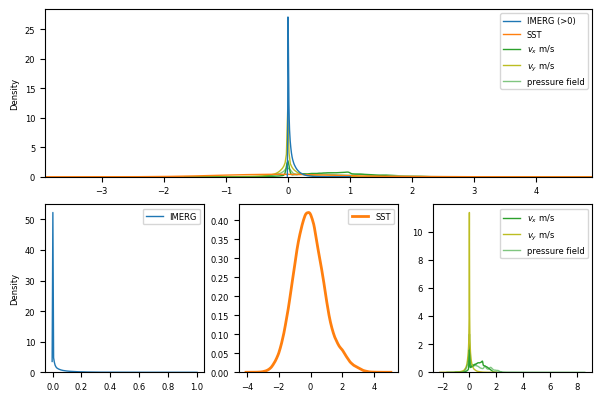

In [20]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

global_params = {
    "font.size": 6,
    # "font.family": "Times New Roman",
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
}

# Create figure and gridspec
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])
plt.rcParams.update(global_params)

# Top plot (spans all three columns)
ax_top = fig.add_subplot(gs[0, :])
sns.kdeplot(
    data_pprocessed[data_pprocessed > 0].flatten(),
    ax=ax_top,
    color="C0",
    linewidth=1,
    label="IMERG (>0)",
    alpha=1,
    zorder=2,
)
sns.kdeplot(sst_data.flatten(), ax=ax_top, color="C1", linewidth=1, label="SST", zorder=1)
sns.kdeplot(v_x.flatten(), ax=ax_top, color="C2", linewidth=1, label=r"$v_{x}$ m/s", zorder=0)
sns.kdeplot(v_y.flatten(), ax=ax_top, color="C8", linewidth=1, label=r"$v_{y}$ m/s", zorder=0)
sns.kdeplot(
    pressure_field.flatten(),
    ax=ax_top,
    color="C12",
    linewidth=1,
    label=f"pressure field",
    alpha=0.6,
    zorder=0,
)
ax_top.legend()
ax_top.set_ylabel("Density")
ax_top.set_xlim(sst_data.flatten().min(), sst_data.flatten().max())

# Bottom left plot
ax_bottom_left = fig.add_subplot(gs[1, 0])
sns.kdeplot(data_pprocessed.flatten(), ax=ax_bottom_left, color="C0", linewidth=1, label="IMERG")
ax_bottom_left.legend(loc="best", fontsize=6)
# ax_bottom_left.set_ylabel('Density', fontsize=6)

# Bottom middle plot
ax_bottom_middle = fig.add_subplot(gs[1, 1])
sns.kdeplot(sst_data.flatten(), ax=ax_bottom_middle, color="C1", linewidth=2, label="SST")
ax_bottom_middle.legend(loc="best", fontsize=6)
ax_bottom_middle.set_ylabel("")

# navier stokes
ax_bottom_right = fig.add_subplot(gs[1, 2])
sns.kdeplot(v_x.flatten(), ax=ax_bottom_right, color="C2", linewidth=1, label=r"$v_{x}$ m/s")
sns.kdeplot(v_y.flatten(), ax=ax_bottom_right, color="C8", linewidth=1, label=r"$v_{y}$ m/s")
sns.kdeplot(
    pressure_field.flatten(),
    ax=ax_bottom_right,
    color="C12",
    linewidth=1,
    label=f"pressure field",
    alpha=0.6,
)
ax_bottom_right.legend(loc="best", fontsize=6)
ax_bottom_right.set_ylabel("")

# Adjust layout
plt.tight_layout()
plt.show()

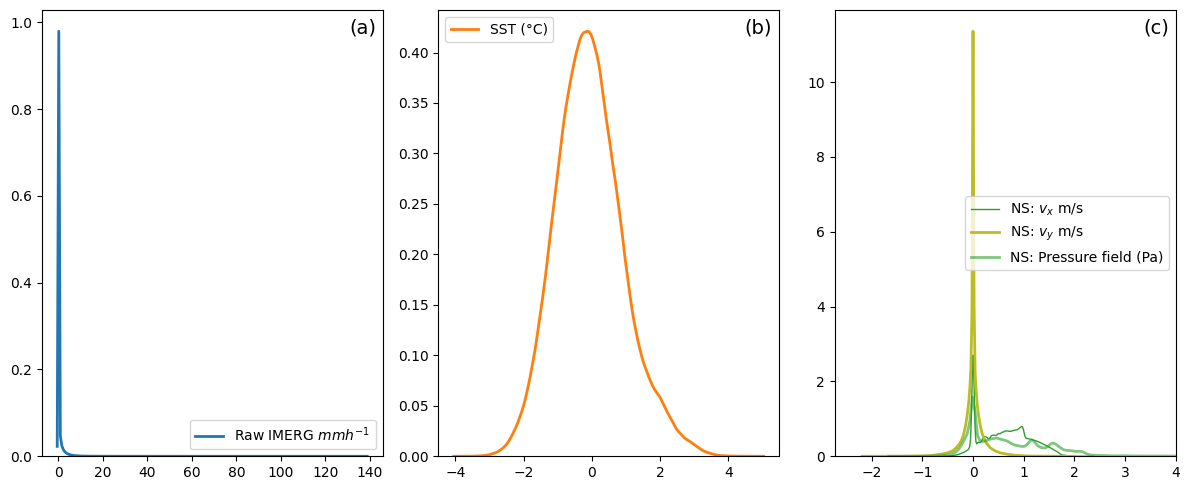

In [21]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

global_params = {
    "font.size": 10,
    # "font.family": "Times New Roman",
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}

# Create figure and gridspec
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 3, height_ratios=[1])
plt.rcParams.update(global_params)

# Bottom left plot
ax_left = fig.add_subplot(gs[0])
sns.kdeplot(
    data_us.flatten(), bw_adjust=5, ax=ax_left, color="C0", linewidth=2, label=r"Raw IMERG $mmh^{-1}$"
)
# sns.kdeplot(data_pprocessed.flatten(), ax=ax_left, color='C0', linewidth=1, label=r'IMERG $mmh^{-1}$')
ax_left.legend(loc="best", fontsize=10)
ax_left.set_ylabel("")
# ax_bottom_left.set_ylabel('Density', fontsize=6)

# Bottom middle plot
ax_middle = fig.add_subplot(gs[1])
sns.kdeplot(sst_data.flatten(), ax=ax_middle, color="C1", linewidth=2, label=r"SST (°C)")
ax_middle.legend(loc="best", fontsize=10)
ax_middle.set_ylabel("")

# navier stokes
ax_right = fig.add_subplot(gs[2])
sns.kdeplot(v_x.flatten(), ax=ax_right, color="C2", linewidth=1, label=r"NS: $v_{x}$ m/s")
sns.kdeplot(v_y.flatten(), ax=ax_right, color="C8", linewidth=2, label=r"NS: $v_{y}$ m/s")
sns.kdeplot(
    pressure_field.flatten(),
    ax=ax_right,
    color="C12",
    linewidth=2,
    label=f"NS: Pressure field (Pa)",
    alpha=0.6,
)
ax_right.legend(loc="best", fontsize=10)
ax_right.set_ylabel("")
ax_right.set_xlim(None, 4)

ax_left.text(
    0.98, 0.98, "(a)", transform=ax_left.transAxes, fontsize=14, va="top", ha="right", color="black"
)
ax_middle.text(
    0.98, 0.98, "(b)", transform=ax_middle.transAxes, fontsize=14, va="top", ha="right", color="black"
)
ax_right.text(
    0.98, 0.98, "(c)", transform=ax_right.transAxes, fontsize=14, va="top", ha="right", color="black"
)

plt.tight_layout()
plt.show()

### END OF SCRIPT.